In [1]:
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from transformers import GPT2TokenizerFast, GPT2LMHeadModel
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import torch.nn.functional as F
from tqdm import tqdm

## Dataset Analysis

In this phase, we analyze the chest x-ray dataset to better understand the distribution of reported problems and evaluate the quality of the data. We identify the most common issues, check for possible class imbalances, and verify the presence of malformed rows. Visualizations will be used to highlight potential criticalities and to prepare for the subsequent phases of the project.

=== ANALISI DEL DATASET ===

Distribuzione dei problemi trovati:
----------------------------------
normal: 1379 occorrenze
Lung: 553 occorrenze
Opacity: 509 occorrenze
Cardiomegaly: 345 occorrenze
Calcinosis: 332 occorrenze
Pulmonary Atelectasis: 330 occorrenze
Calcified Granuloma: 276 occorrenze
Thoracic Vertebrae: 256 occorrenze
Cicatrix: 196 occorrenze
Spine: 174 occorrenze
Markings: 167 occorrenze
Pleural Effusion: 160 occorrenze
Aorta: 158 occorrenze
Diaphragm: 140 occorrenze
Density: 129 occorrenze
Atherosclerosis: 125 occorrenze
Deformity: 124 occorrenze
Airspace Disease: 123 occorrenze
Catheters, Indwelling: 121 occorrenze
Scoliosis: 118 occorrenze
Nodule: 116 occorrenze
Granulomatous Disease: 107 occorrenze
Surgical Instruments: 105 occorrenze
No Indexing: 92 occorrenze
Fractures, Bone: 89 occorrenze
Aorta, Thoracic: 89 occorrenze
Technical Quality of Image Unsatisfactory: 84 occorrenze
Costophrenic Angle: 79 occorrenze
Osteophyte: 70 occorrenze
Pulmonary Congestion: 68 occor

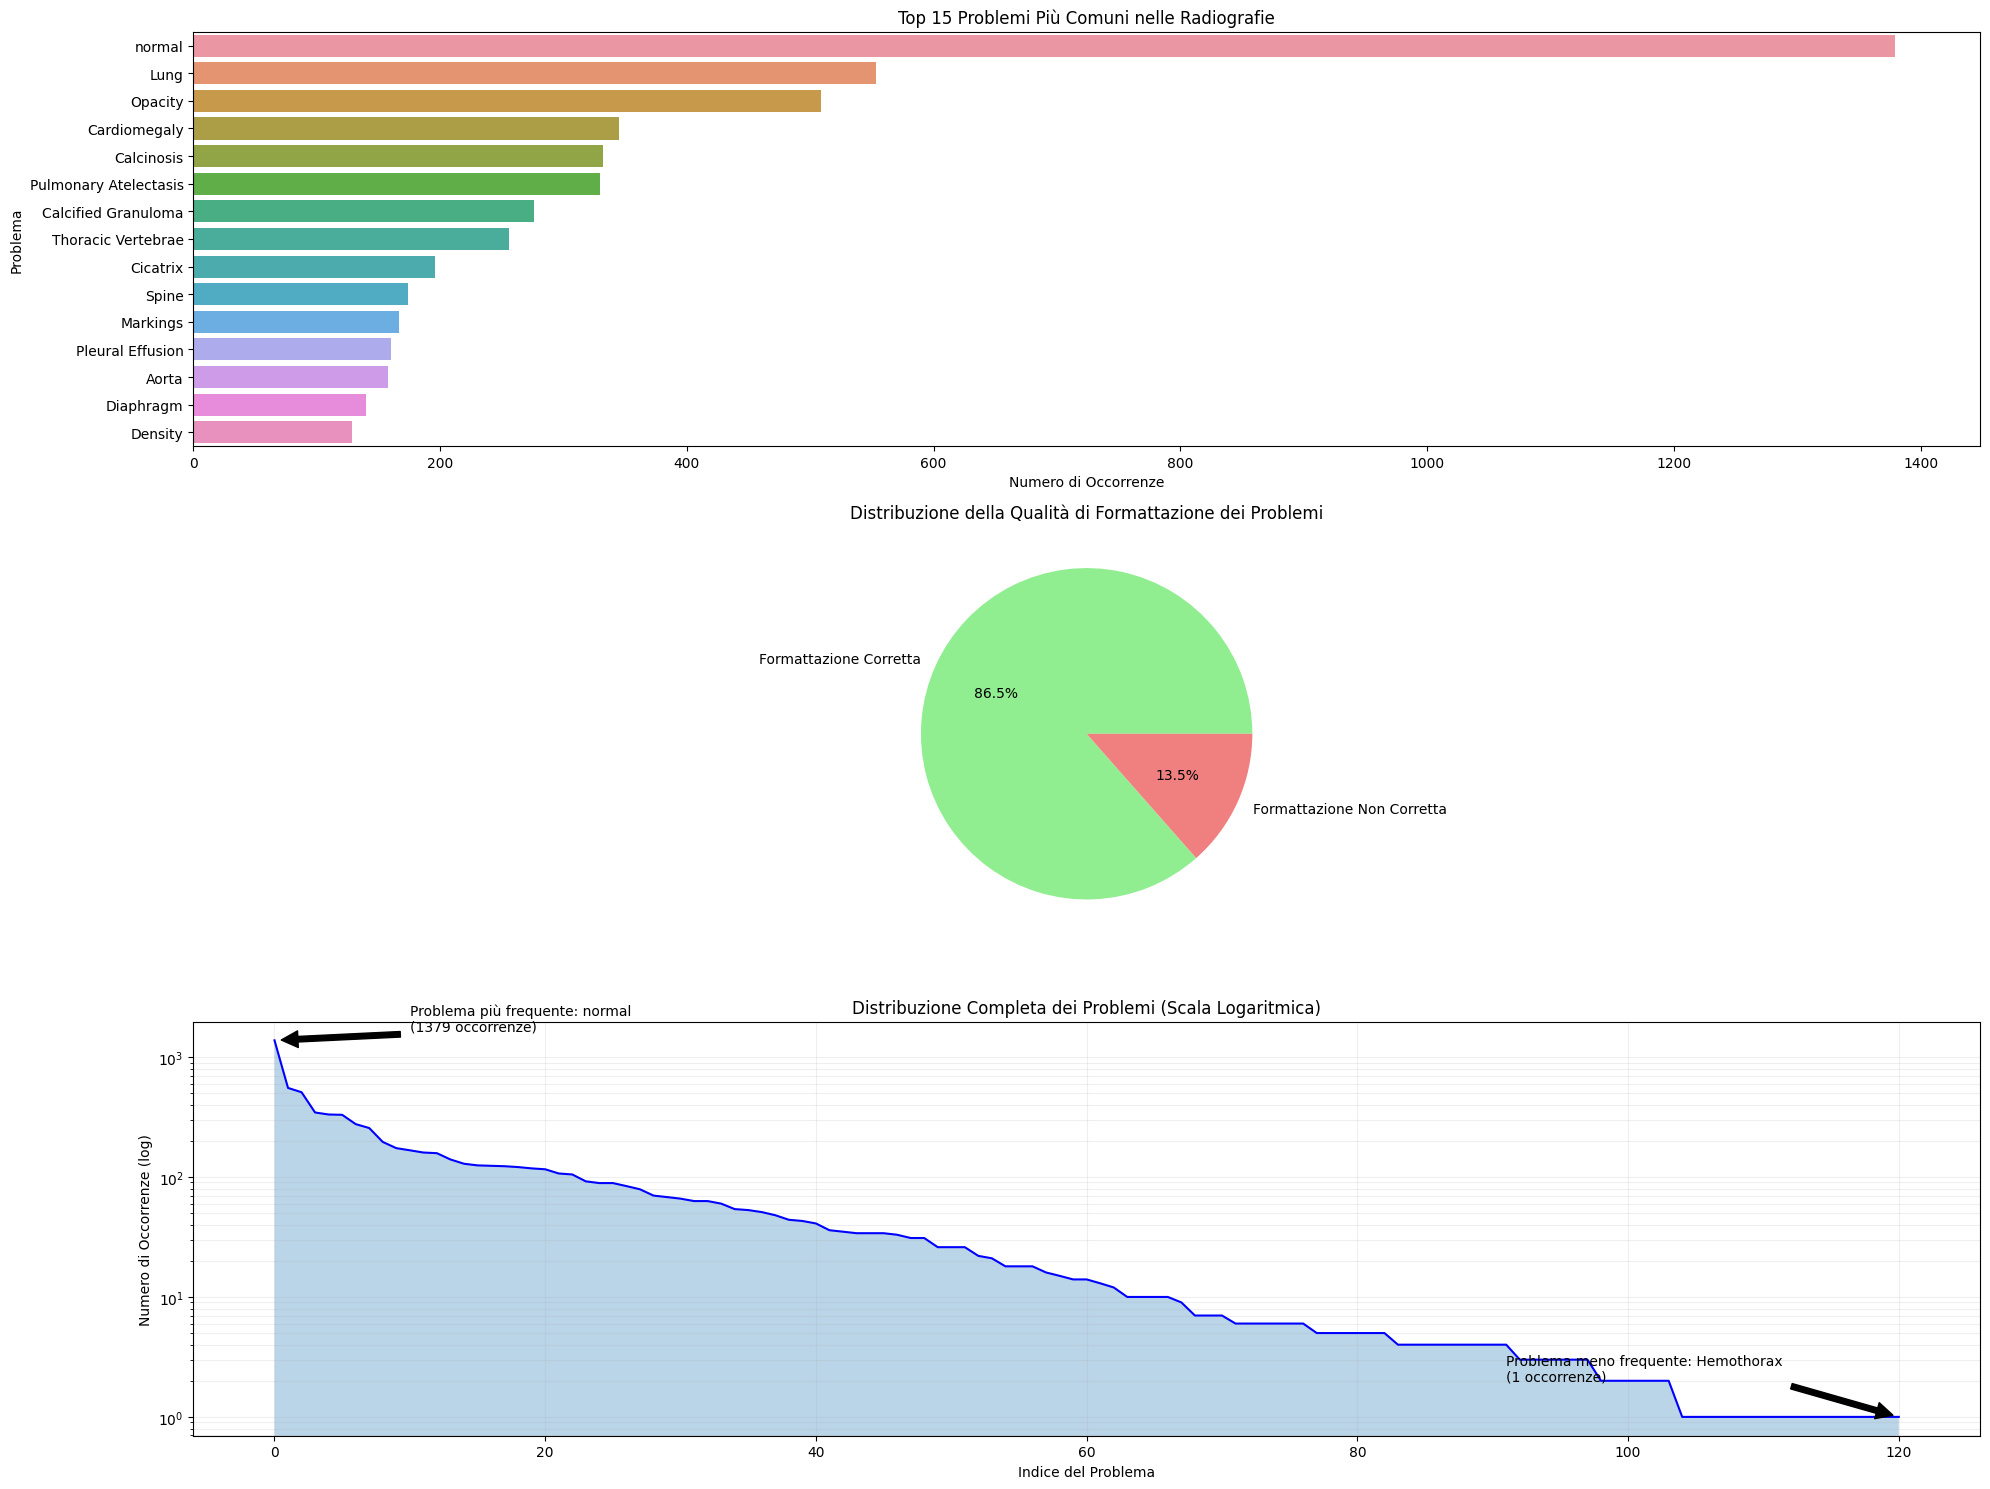

In [2]:
# DATASET ANALYSIS, PROBLEMS COUNT, DISTRIBUTION OF CLASS OCCURRENCES
# PLOT VISUALIZATION
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def analyze_xray_dataset(reports_path, projections_path, img_dir):
    """
    Analizza il dataset di radiografie toraciche, focalizzandosi sui problemi riscontrati
    e identificando le righe con problemi di formattazione.
    
    Parameters:
    reports_path (str): Percorso del file CSV dei referti
    projections_path (str): Percorso del file CSV delle proiezioni
    img_dir (str): Directory contenente le immagini
    """
    # Caricamento dei dati
    reports_df = pd.read_csv(reports_path)
    projections_df = pd.read_csv(projections_path)
    
    print("=== ANALISI DEL DATASET ===\n")
    
    # Analisi dei problemi
    # Separiamo i problemi multipli (divisi da ;)
    all_problems = []
    
    # Conteggio problemi malformattati
    bad_formatting_count = 0
    well_formatted_count = 0
    
    for problems in reports_df['Problems'].dropna():
        problems_str = str(problems)
        # Verifica se ci sono problemi di formattazione
        if problems_str == "No Indexing" or "," in problems_str:
            bad_formatting_count += 1
        else:
            well_formatted_count += 1
        all_problems.extend([p.strip() for p in problems_str.split(';')])
    
    # Conteggio dei problemi
    problem_counts = pd.Series(all_problems).value_counts()
    
    print("Distribuzione dei problemi trovati:")
    print("----------------------------------")
    for problem, count in problem_counts.items():
        print(f"{problem}: {count} occorrenze")
    
    print(f"\nNumero totale di problemi unici: {len(problem_counts)}\n")
    
    print("Analisi della formattazione:")
    print("--------------------------")
    print(f"Righe con formattazione corretta: {well_formatted_count}")
    print(f"Righe con formattazione non corretta: {bad_formatting_count}")
    
    # Creiamo una figura con 3 subplot
    plt.figure(figsize=(20, 15))
    
    # 1. Top 15 problemi
    plt.subplot(3, 1, 1)
    top_problems = problem_counts.head(15)
    sns.barplot(x=top_problems.values, y=top_problems.index)
    plt.title('Top 15 Problemi Più Comuni nelle Radiografie')
    plt.xlabel('Numero di Occorrenze')
    plt.ylabel('Problema')
    
    # 2. Grafico a torta per la qualità della formattazione
    plt.subplot(3, 1, 2)
    labels = ['Formattazione Corretta', 'Formattazione Non Corretta']
    sizes = [well_formatted_count, bad_formatting_count]
    colors = ['lightgreen', 'lightcoral']
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
    plt.title('Distribuzione della Qualità di Formattazione dei Problemi')
    
    # 3. Distribuzione completa dei problemi (scala logaritmica)
    plt.subplot(3, 1, 3)
    
    # Creiamo un grafico a linea per tutti i problemi
    x = range(len(problem_counts))
    plt.plot(x, problem_counts.values, 'b-')
    plt.fill_between(x, problem_counts.values, alpha=0.3)
    plt.yscale('log')  # Scala logaritmica per meglio visualizzare le differenze
    plt.title('Distribuzione Completa dei Problemi (Scala Logaritmica)')
    plt.xlabel('Indice del Problema')
    plt.ylabel('Numero di Occorrenze (log)')
    plt.grid(True, which="both", ls="-", alpha=0.2)
    
    # Aggiungiamo alcune annotazioni per evidenziare lo sbilanciamento
    plt.annotate(f'Problema più frequente: {problem_counts.index[0]}\n({problem_counts.values[0]} occorrenze)',
                xy=(0, problem_counts.values[0]),
                xytext=(10, problem_counts.values[0]*1.2),
                arrowprops=dict(facecolor='black', shrink=0.05))
    
    plt.annotate(f'Problema meno frequente: {problem_counts.index[-1]}\n({problem_counts.values[-1]} occorrenze)',
                xy=(len(problem_counts)-1, problem_counts.values[-1]),
                xytext=(len(problem_counts)-30, problem_counts.values[-1]*2),
                arrowprops=dict(facecolor='black', shrink=0.05))
    
    plt.tight_layout()
    plt.show()
    
    return problem_counts, well_formatted_count, bad_formatting_count

PROJECTIONS_PATH = '/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv'
REPORTS_PATH = '/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv'
IMG_DIR = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized/'

problems_count, missing_probs, missing_imgs = analyze_xray_dataset(
    REPORTS_PATH,
    PROJECTIONS_PATH,
    IMG_DIR
)

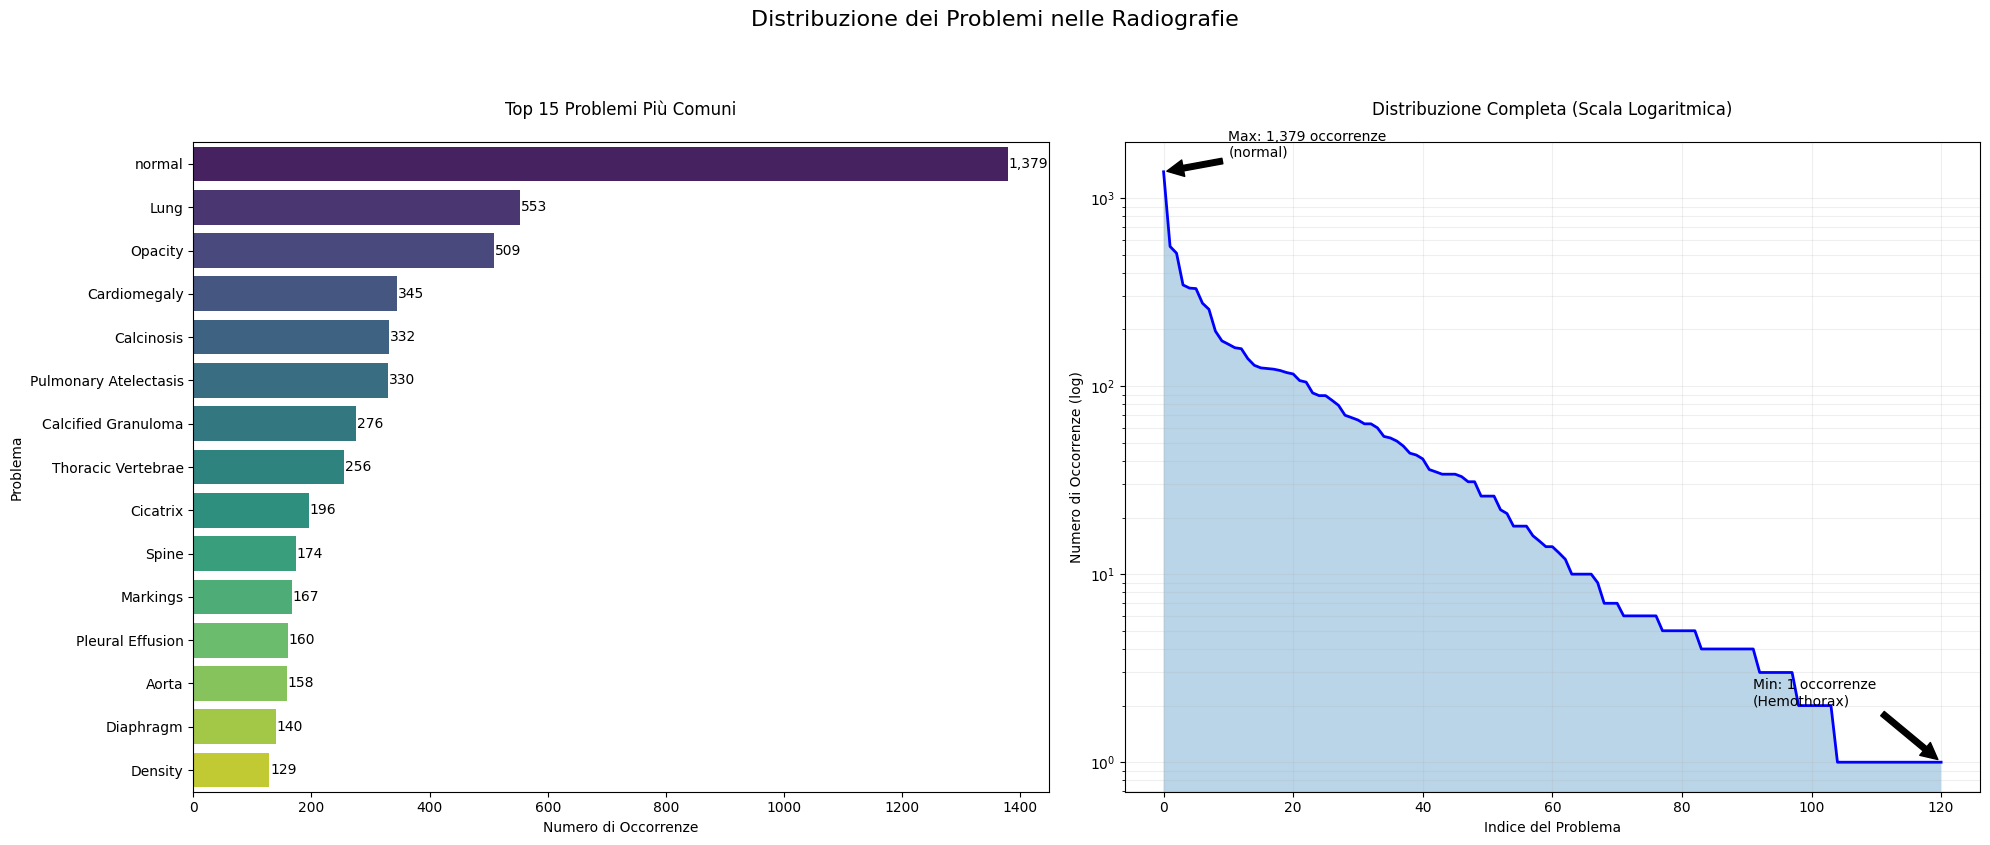


Statistiche sulla distribuzione dei problemi:
Numero totale di problemi unici: 121
Problema più frequente: normal (1,379 occorrenze)
Problema meno frequente: Hemothorax (1 occorrenze)


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_problem_distribution(reports_path):
    # Caricamento e preprocessing dei dati
    reports_df = pd.read_csv(reports_path)
    
    # Estrazione e conteggio dei problemi
    all_problems = []
    for problems in reports_df['Problems'].dropna():
        problems_str = str(problems)
        all_problems.extend([p.strip() for p in problems_str.split(';')])
    
    problem_counts = pd.Series(all_problems).value_counts()
    
    # Creazione della figura con due subplot affiancati
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle('Distribuzione dei Problemi nelle Radiografie', fontsize=16, y=1.05)
    
    # Plot 1: Top 15 problemi (scala normale)
    top_15 = problem_counts.head(15)
    sns.barplot(x=top_15.values, y=top_15.index, ax=ax1, palette='viridis')
    ax1.set_title('Top 15 Problemi Più Comuni', pad=20)
    ax1.set_xlabel('Numero di Occorrenze')
    ax1.set_ylabel('Problema')
    
    # Aggiungi i valori sulle barre
    for i, v in enumerate(top_15.values):
        ax1.text(v + 1, i, f'{v:,}', va='center')
    
    # Plot 2: Distribuzione completa (scala logaritmica)
    x = range(len(problem_counts))
    ax2.plot(x, problem_counts.values, 'b-', linewidth=2)
    ax2.fill_between(x, problem_counts.values, alpha=0.3)
    ax2.set_yscale('log')
    ax2.set_title('Distribuzione Completa (Scala Logaritmica)', pad=20)
    ax2.set_xlabel('Indice del Problema')
    ax2.set_ylabel('Numero di Occorrenze (log)')
    ax2.grid(True, which="both", ls="-", alpha=0.2)
    
    # Aggiungi annotazioni per i valori estremi
    ax2.annotate(f'Max: {problem_counts.values[0]:,} occorrenze\n({problem_counts.index[0]})',
                xy=(0, problem_counts.values[0]),
                xytext=(10, problem_counts.values[0]*1.2),
                arrowprops=dict(facecolor='black', shrink=0.05))
    
    ax2.annotate(f'Min: {problem_counts.values[-1]:,} occorrenze\n({problem_counts.index[-1]})',
                xy=(len(problem_counts)-1, problem_counts.values[-1]),
                xytext=(len(problem_counts)-30, problem_counts.values[-1]*2),
                arrowprops=dict(facecolor='black', shrink=0.05))
    
    plt.tight_layout()
    plt.show()
    
    # Stampa alcune statistiche
    print("\nStatistiche sulla distribuzione dei problemi:")
    print(f"Numero totale di problemi unici: {len(problem_counts):,}")
    print(f"Problema più frequente: {problem_counts.index[0]} ({problem_counts.values[0]:,} occorrenze)")
    print(f"Problema meno frequente: {problem_counts.index[-1]} ({problem_counts.values[-1]:,} occorrenze)")

# Esempio di utilizzo
REPORTS_PATH = '/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv'
plot_problem_distribution(REPORTS_PATH)

---
To address the issues identified during the dataset analysis, we implemented a series of targeted solutions to improve data quality and its usefulness for subsequent analyses. Below are the main interventions carried out:

### Creation of a New Dataset
We reorganized the dataset by removing all chest x-rays without associated problems or descriptions, and vice versa. This allowed us to focus the analysis exclusively on complete and meaningful data, avoiding the presence of irrelevant or potentially misleading information.

### Removal of Problems with Few Occurrences
All problems with an occurrence count too low (in the range of tens) were removed. This decision was motivated by several reasons:
- **Limited analytical contribution:** Problems with few occurrences do not significantly contribute to the generalization of machine learning models.
- **Risk of overfitting:** Rare problems could lead models to focus on non-generalizable patterns.
- **Reduced complexity:** Eliminating rare problems simplified the dataset, making analysis and interpretation more manageable.

### Dataset Class Categorization
In this updated approach, we simplified the dataset by grouping the various problems into four categories based on the affected body system. This strategy was adopted to ensure a more balanced dataset and to improve model performance. The new categories are:

- **No Problem:** Represents cases where no abnormalities were detected.
- **Pulmonary System** (Sistema Polmonare): Includes issues related to the lungs and respiratory system.
- **Cardiovascular System** (Sistema Cardiovascolare): Encompasses problems associated with the heart and blood vessels.
- **Musculoskeletal System** (Sistema Muscoloscheletrico): Covers conditions affecting bones, muscles, and connective tissues.

In [4]:
import pandas as pd
    
# Caricamento dei file CSV
df_image = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv')
df_report = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv')

# Creazione di un DataFrame vuoto per le immagini frontale, laterale, didascalia e problemi
df = pd.DataFrame({'front_img': [], 'lateral_img': [], 'captions': [], 'problems': []})

# Ciclo attraverso ogni immagine nel DataFrame delle immagini
for uid in df_image['uid'].unique():
    # Trovo tutte le immagini per ogni 'uid'
    front_image = df_image.loc[(df_image['uid'] == uid) & (df_image['projection'] == 'Frontal')]
    lateral_img = df_image.loc[(df_image['uid'] == uid) & (df_image['projection'] == 'Lateral')]
    
    # Se ci sono sia immagini frontali che laterali
    if not front_image.empty and not lateral_img.empty:
        # Trovo la didascalia corrispondente
        caption = df_report.loc[df_report['uid'] == uid, 'findings'].values[0]
        # Trovo i problemi corrispondenti
        problems = df_report.loc[df_report['uid'] == uid, 'Problems'].values[0]
        
        # Aggiungo la riga al DataFrame
        df = pd.concat([df, pd.DataFrame([{
            'front_img': front_image.iloc[0]['filename'],
            'lateral_img': lateral_img.iloc[0]['filename'],
            'captions': caption,
            'problems': problems
        }])], axis=0)

# Aggiorno i percorsi delle immagini
loc = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized/'
df['front_img'] = loc + df['front_img']
df['lateral_img'] = loc + df['lateral_img']

# Reset dell'indice per assicurarsi che sia unico
#cosi facendo ogni riga ha un id univoco
df = df.reset_index(drop=True)

# Mostra il risultato finale
print(df.head())

                                           front_img  \
0  /kaggle/input/chest-xrays-indiana-university/i...   
1  /kaggle/input/chest-xrays-indiana-university/i...   
2  /kaggle/input/chest-xrays-indiana-university/i...   
3  /kaggle/input/chest-xrays-indiana-university/i...   
4  /kaggle/input/chest-xrays-indiana-university/i...   

                                         lateral_img  \
0  /kaggle/input/chest-xrays-indiana-university/i...   
1  /kaggle/input/chest-xrays-indiana-university/i...   
2  /kaggle/input/chest-xrays-indiana-university/i...   
3  /kaggle/input/chest-xrays-indiana-university/i...   
4  /kaggle/input/chest-xrays-indiana-university/i...   

                                            captions  \
0  The cardiac silhouette and mediastinum size ar...   
1  Borderline cardiomegaly. Midline sternotomy XX...   
2                                                NaN   
3  There are diffuse bilateral interstitial and a...   
4  The cardiomediastinal silhouette and pulmon

In [5]:
import pandas as pd
normal_rows = df[df['problems'].str.contains('normal', na=False)]
print(f"Numero di righe con 'Normal': {len(normal_rows)}")
rows_to_remove = normal_rows.sample(frac=0.5, random_state=42).index

print(f"lunghezza df prima di drop: {len(df)}")
df = df.drop(rows_to_remove)
print(f"lunghezza prima df dopo drop: {len(df)}")

Numero di righe con 'Normal': 1244
lunghezza df prima di drop: 3388
lunghezza prima df dopo drop: 2766


In [6]:
# Calcola le occorrenze di ciascun problema
problem_counts = {}
for problems in df['problems'].dropna():
    for problem in problems.split(';'):
        problem = problem.strip()  # Rimuovi spazi extra
        problem_counts[problem] = problem_counts.get(problem, 0) + 1

# Definisci i problemi da eliminare
problems_to_delete = [
    "No Indexing",
    "Technical Quality of Image Unsatisfactory",
    "Foreign Bodies",
    "Calcinosis",
    "Density",
    "Diaphragm",
    "Diaphragmatic Eventration",
    "Hernia, Hiatal",
    "Catheters, Indwelling",
    "Surgical Instruments",
    "Implanted Medical Device",
    "Medical Device",
    "Lucency",
    "Tube, Inserted",
    "Markings",
]

# Funzione per filtrare i problemi di una riga
def filter_problems(problems, threshold=20):
    """
    Rimuove i problemi con occorrenze inferiori al valore di soglia.
    Rimuove anche il problema "No Indexing".
    Restituisce una stringa con i problemi filtrati o None se non ne rimane nessuno.
    """
    if not problems:  # Controlla se il campo è vuoto o NaN
        return None
    filtered_problems = [
        problem.strip() for problem in problems.split(';')
        if problem_counts.get(problem.strip(), 0) >= threshold and problem.strip() not in problems_to_delete
    ]
    return ';'.join(filtered_problems) if filtered_problems else None

# Applica il filtro ai problemi
df['problems'] = df['problems'].apply(filter_problems)

# Elimina le righe senza problemi rimanenti
df = df.dropna(subset=['problems']).reset_index(drop=True)

# Risultati
print(f"Dataset dopo la pulizia: {len(df)} righe rimanenti.")


Dataset dopo la pulizia: 2494 righe rimanenti.


In [7]:
import pandas as pd

def count_problems_occurrences(df):
    """
    Conta e stampa i problemi e il numero di occorrenze di ciascuno nel dataset.
    
    Args:
    df (pd.DataFrame): DataFrame contenente la colonna 'problems'.
    """
    # Controllo che la colonna 'problems' esista
    if 'problems' not in df.columns:
        print("La colonna 'problems' non è presente nel DataFrame.")
        return
    
    # Separare i problemi se sono multipli (ad esempio, separati da punto e virgola)
    all_problems = df['problems'].dropna().str.split(';')
    
    # Flatten della lista di problemi e conteggio delle occorrenze
    problem_counts = {}
    for problem_list in all_problems:
        for problem in problem_list:
            problem = problem.strip()  # Rimuovere eventuali spazi vuoti all'inizio o alla fine
            problem_counts[problem] = problem_counts.get(problem, 0) + 1
    
    # Ordinare i problemi per numero di occorrenze (decrescente)
    sorted_problems = sorted(problem_counts.items(), key=lambda x: x[1], reverse=True)
    
    # Stampare i risultati
    print("Problemi e occorrenze:")
    for problem, count in sorted_problems:
        print(f"{problem}: {count}")

# Esempio di utilizzo della funzione
count_problems_occurrences(df)

Problemi e occorrenze:
normal: 622
Lung: 490
Opacity: 430
Cardiomegaly: 288
Pulmonary Atelectasis: 286
Calcified Granuloma: 241
Thoracic Vertebrae: 217
Cicatrix: 171
Spine: 150
Aorta: 135
Pleural Effusion: 132
Nodule: 106
Atherosclerosis: 103
Granulomatous Disease: 101
Deformity: 99
Airspace Disease: 99
Scoliosis: 95
Fractures, Bone: 77
Aorta, Thoracic: 76
Costophrenic Angle: 66
Osteophyte: 64
Spondylosis: 61
Pulmonary Congestion: 61
Infiltrate: 53
Emphysema: 50
Granuloma: 50
Thickening: 47
Pulmonary Disease, Chronic Obstructive: 44
Cardiac Shadow: 44
Pulmonary Edema: 39
Pneumonia: 34
Arthritis: 32
Pulmonary Emphysema: 32
Consolidation: 24
Mediastinum: 24
Kyphosis: 24
Bone Diseases, Metabolic: 23
Spinal Fusion: 21
Pneumothorax: 20


### Parametric Design for Flexible Classification

To enhance the model's flexibility, we designed the architecture to be parametrizable with respect to the number of output nodes. This enables the same code to handle binary, multiclass, or even multi-label classification problems with minimal changes. By simply modifying the `num_classes` parameter, the model can be adjusted, for example, to predict:

- **4 classes**: For example, categorizing data into:
  - "No Problem"
  - "Pulmonary System"
  - "Cardiovascular System"
  - "Musculoskeletal System"
- **3 classes**: When combining certain categories or simplifying the output.
- **Binary classification**: Distinguishing between:
  - "Problem"
  - "No Problem."

In [8]:
categories = {
    "Nessun Problema": [
        "normal"
    ],
    "Sistema Polmonare": [
        "Lung",
        "Pulmonary Atelectasis",
        "Pulmonary Congestion",
        "Pulmonary Disease, Chronic Obstructive",
        "Pulmonary Emphysema",
        "Pulmonary Edema",
        "Infiltrate",
        "Emphysema",
        "Granuloma",
        "Airspace Disease",
        "Pleural Effusion",
        "Pneumonia",
        "Thickening",
        "Consolidation",
        "Pneumothorax",
        "Granulomatous Disease",
        "Calcified Granuloma",
        "Costophrenic Angle",
    ],
    "Sistema Cardiovascolare": [
        "Cardiomegaly",
        "Aorta",
        "Aorta, Thoracic",
        "Atherosclerosis",
        "Pulmonary Edema",
        "Cardiac Shadow",
        "Mediastinum",
    ],
    "Sistema Muscoloscheletrico": [
        "Thoracic Vertebrae",
        "Spine",
        "Scoliosis",
        "Kyphosis",
        "Deformity",
        "Osteophyte",
        "Spondylosis",
        "Cicatrix",
        "Fractures, Bone",
        "Bone Diseases, Metabolic",
        "Spinal Fusion",
        "Arthritis",
    ]
}
# Creazione di una nuova colonna 'categories' basata sui problemi
def assign_categories(problems, categories_dict):
    """
    Assegna una macrocategoria in base ai problemi usando il dizionario di categorie.
    """
    if not problems:  # Se non ci sono problemi, restituisci None
        return None
    
    assigned_categories = set()  # Per tenere traccia delle macrocategorie assegnate
    for problem in problems.split(';'):
        problem = problem.strip()
        for category, problem_list in categories_dict.items():
            if problem in problem_list:
                assigned_categories.add(category)
    
    # Se nessuna macrocategoria è assegnata, restituisci None
    if len(assigned_categories) == 0:
        return None
    # Se più di una macrocategoria è assegnata, restituisci 'Multiple'
    elif len(assigned_categories) > 1:
        return 'Multiple'
    # Altrimenti, restituisci l'unica macrocategoria assegnata
    else:
        return assigned_categories.pop()

# Applicazione della funzione al dataset
df['categories'] = df['problems'].apply(lambda x: assign_categories(x, categories))

# Rimuove le righe senza macrocategorie assegnate
df = df.dropna(subset=['categories'])

# Rimuove le righe con più di una macrocategoria assegnata
df = df[df['categories'] != 'Multiple']

# Reset dell'indice dopo la pulizia
df = df.reset_index(drop=True)

# Mostra il risultato finale
print(f"Dataset dopo la pulizia: {len(df)} righe rimanenti.")

Dataset dopo la pulizia: 1716 righe rimanenti.


In [9]:
# Conta le occorrenze di ciascun macroproblema (categoria)
category_counts = df['categories'].value_counts()
# Stampa le occorrenze
print("Occorrenze di ciascun macroproblema:")
print(category_counts)

Occorrenze di ciascun macroproblema:
categories
Nessun Problema               622
Sistema Polmonare             616
Sistema Muscoloscheletrico    324
Sistema Cardiovascolare       154
Name: count, dtype: int64


In [10]:
#VARIABILE CHE VIENE USATA IN MOLTE CELLE E NEL MODELLO
num_class_pred = 4

In [11]:
from transformers import AutoTokenizer, GPT2TokenizerFast

# Use GPT2 tokenizer which is better suited for text generation
#Viene caricato il tokenizer specifico per il modello GPT-2 utilizzando il metodo from_pretrained()
#Il tokenizer è utilizzato per trasformare il testo in sequenze di token (unità minime di significato per il modello) e viceversa.
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
#Il token di padding (pad_token) viene impostato per il tokenizer. In molti modelli, il padding è utilizzato per rendere le sequenze di input di lunghezza uguale, riempiendo le sequenze più corte con un token speciale.

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [12]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((384, 384)), #resize delle immagini nel formato standard
    transforms.ToTensor(),  #Trasforma l'immagine in un tensore PyTorch. Questa operazione normalizza i valori dei pixel
])

---
## Dataset Encoding and Loading Function

The `LoadDataset` class is used to load and preprocess the dataset containing images and associated information, such as captions and problems. Text encoding is performed using a tokenizer, transforming the caption and problem into sequences of numerical tokens. Additionally, risk categories are encoded using one-hot encoding.  
For each dataset example, the frontal and lateral images, the encoded caption and problem, as well as the associated risk category in one-hot format, are returned.

In [13]:
from torch.utils.data import Dataset
from PIL import Image

'''
caption e problem vengono codificati attraverso il tokenizer. Trasforma il testo in una sequenza di token (id numerici).
Questo processo restituisce: 
- input_ids: rappresentazione numerica del testo.
- attention_mask: maschera che indica quali token solo validi.
Esempio:
1)  "La radiografia mostra un'area opaca nel lobo superiore destro."
2)  ['La', 'radiografia', 'mostra', "un'", 'area', 'opaca', 'nel', 'lobo', 'superiore', 'destro', '.']
3)  [101, 4120, 5123, 1132, 4172, 3090, 1209, 8765, 3040, 8712, 102]   101 e 102 sono caratteri speciali di inizio e fine
4)  Input tokenizzato: [101, 4120, 5123, 1132, 4172, 3090, 1209, 8765, 3040, 8712, 102, 0, 0, 0, ...]
    Attention mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...]
Poiché i modelli lavorano con sequenze di lunghezza fissa (ad esempio 128 token), i testi più corti vengono riempiti con token 
speciali (padding, 0). La attention mask indica quali token fanno parte del testo originale (1) e quali sono padding (0).
'''
class LoadDataset(Dataset):
    def __init__(self, df):
        self.front_images = df['front_img'].values  # Colonna delle immagini frontali
        self.lateral_imgs = df['lateral_img'].values    # Colonna delle immagini laterali
        self.captions = df['captions'].values          # Colonna delle didascalie
        self.problems = df['problems'].values  # Colonna dei problemi
        self.zone_categories = df['categories'].values  # Colonna delle categorie di rischio

        # Mappa delle categorie di rischio a indici (per la codifica one-hot encoding)
        self.risk_mapping = {
            'Nessun Problema': 0,
            'Sistema Polmonare': 1,
            'Sistema Cardiovascolare': 2,
            'Sistema Muscoloscheletrico': 3
        }
        
    # Il metodo __getitem__ recupera le immagini frontale e laterale e la didascalia corrispondente
    def __getitem__(self, idx):
        # Carica l'immagine frontale e laterale
        front_image_path = str(self.front_images[idx])
        lateral_img_path = str(self.lateral_imgs[idx])
        
        # Apri le immagini e convertele in RGB
        front_image = Image.open(front_image_path).convert("RGB")
        lateral_img = Image.open(lateral_img_path).convert("RGB")
        
        # Applica le trasformazioni alle immagini (da definire)
        front_image = transform(front_image)
        lateral_img = transform(lateral_img)

        # Recupera la didascalia, il problem e la categoria di rischio
        caption = str(self.captions[idx])
        problem = str(self.problems[idx])
        categories = self.zone_categories[idx] 
        
        # Codifica la didascalia utilizzando il tokenizer
        encoded_caption = tokenizer(
            caption,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Codifica il problema utilizzando il tokenizer
        encoded_problem = tokenizer(
            problem,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Codifica one-hot della categoria di rischio
        categories = self.zone_categories[idx]
        risk_label = self.risk_mapping.get(categories, 0)  # Default a 0 se la categoria non esiste
        risk_one_hot = F.one_hot(torch.tensor(risk_label), num_classes=num_class_pred).float()
        
        # Restituisce le immagini e la didascalia codificata e il problema codificato
        return {
            'front_pixel_values': front_image,  # Immagine frontale
            'lateral_pixel_values': lateral_img,    # Immagine laterale
            'input_ids_caption': encoded_caption['input_ids'].squeeze(0),  # ID di input della didascalia
            'attention_mask_caption': encoded_caption['attention_mask'].squeeze(0),  # Attention Mask per la didascalia
            'categories': risk_one_hot 
        }

    def __len__(self):  # Metodo che restituisce la lunghezza del dataset
        return len(self.front_images)

In [14]:
from sklearn.model_selection import train_test_split

# Suddividere il DataFrame in train, test e validazione
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
train_df, valid_df = train_test_split(train_df, test_size=0.3, shuffle=True, random_state=42)

# Creazione dei dataset personalizzati per train, test e validazione
train_ds = LoadDataset(train_df)
test_ds = LoadDataset(test_df)
valid_ds = LoadDataset(valid_df)

---
## ResNet50 as an Encoder for Feature Extraction with Fine-Tuning

Among the various trials and pretrained networks tested, ResNet50 proved to be the most effective, particularly considering its simplicity compared to more complex networks. In this approach, we used ResNet50 as a pretrained model and applied a fine-tuning strategy by unfreezing only the last `n` layers for training.

### Code Description:

The `ResNetEncoder` class implements a ResNet50 model with some modifications to adapt it to our specific use case:

1. **Loading the Pretrained Model**:
   - The ResNet50 model is loaded with pretrained weights from ImageNet using `models.resnet50(pretrained=True)`.

2. **Removing the Classification Head**:
   - The classification head (`fc` layer) is removed and replaced with an `nn.Identity()` operation, allowing the extraction of features without performing classification.

3. **Freezing the Weights**:
   - All model parameters are initially frozen (`requires_grad = False`), preventing the weights from being updated during the training phase.

4. **Unfreezing the Last `trainable_layers`**:
   - The `_unfreeze_last_layers` function unfreezes the last `n` layers, enabling them to be trained. This allows for effective fine-tuning, focusing only on a subset of the model.

5. **Forward Pass**:
   - In the `forward` method, the ResNet50 model returns a *feature vector* of size 2048, representing the extracted features from the image.


In [15]:
import torch
import torch.nn as nn
from torchvision import models

class ResNetEncoder(nn.Module):
    def __init__(self, trainable_layers=6):
        super(ResNetEncoder, self).__init__()
        self.model = models.resnet50(pretrained=True)
        # Rimuove la testa di classificazione
        self.model.fc = nn.Identity()
        
        # Congela tutto
        for param in self.model.parameters():
            param.requires_grad = False
        
        # Sblocca (unfreeze) gli ultimi `trainable_layers` layer
        self._unfreeze_last_layers(trainable_layers)

    def _unfreeze_last_layers(self, trainable_layers):
        # Ottieni i layer in ordine (children) e sblocca gli ultimi n
        children = list(self.model.children())  
        for layer in children[-trainable_layers:]:
            for param in layer.parameters():
                param.requires_grad = True

    def forward(self, x):
        # Restituisce il feature vector (dim=2048)
        return self.model(x)  # shape [B, 2048]

### Model Weight Updates During Training

The weight update process during model training involves two separate loss functions: **caption loss** and **classification loss**. The weight update flow can be divided into two main parts, depending on which components of the model are involved in each loss. Here are the details:

### 1. **Caption Loss**
The **caption loss** is associated with the image caption generation part of the model, which involves the GPT-2 decoder and the feature projection.

- **Components updated by caption loss**:
  - **GPT-2 Decoder**: The weights of the GPT-2 decoder are updated based on the loss from caption generation. The model predicts the words in the caption, and the loss is calculated using **cross-entropy** between the generated logits and the real captions.
  - **Feature Projection Layer**: This layer projects the concatenated image features into a space compatible with the GPT-2 decoder. The weights of this projection are updated to optimize caption generation quality.
  - **Projection Layer Norm**: It is updated to improve the normalization of projected values and optimize the information flow to the GPT-2 decoder.

- **Loss Calculation**:
  - The caption loss is computed using the `MedicalCaptionLoss` function, which takes the logits from the GPT-2 decoder and the real captions, evaluating the error between the two. This error is backpropagated through the decoder and the feature projection.

- **Weights Updated**:
  - The weights of the GPT-2 decoder, feature projection layer, and normalization layer are updated during backpropagation based on the **caption loss**.

### 2. **Classification Loss**
The **classification loss** is associated with the risk classification part of the model, involving the ResNet encoders and the separate classifier.

- **Components updated by classification loss**:
  - **ResNet Encoders (front and side)**: Both encoders (for the front and side images) are updated based on the classification loss. These encoders extract features from the images, and their weights are optimized for risk classification. This optimization improves the feature extraction for accurate classification.
  - **Classifier**: The classifier, which takes the concatenated features from the front and side images as input, is updated to optimize the classification logits. This is done to improve the model’s ability to assign correct risk categories.

- **Loss Calculation**:
  - The classification loss is calculated using the **FocalLoss**, which takes the classification logits and the real risk labels (risk categories). The loss is used to optimize the model’s ability to make accurate risk predictions.

- **Weights Updated**:
  - The weights of the ResNet encoders and classifier are updated during backpropagation based on the **classification loss**.

### 3. **Weight Updates: Leveraging a Shared Latent Space**
The architecture is designed around a **shared latent space** that bridges the **caption generation** and **classification tasks**. This shared space is updated by both losses, enabling better generalization of the model. By passing through this shared representation, even GPT-2 indirectly influences and reshapes the original latent space. This is beneficial for ensuring that both tasks (captioning and classification) learn complementary features, enhancing the overall performance of the model.
Both the **caption loss** and **classification loss** are summed to calculate the **total loss**, which is used for backpropagation. The gradients computed from the **total loss** (`total_loss.backward()`) flow through the entire network, updating the shared latent space. The model employs two **different learning rates** for the two tasks to balance their contributions.

In [16]:
import torch.nn as nn
from transformers import GPT2LMHeadModel, GPT2Config
import torchvision.models as models

class ImageCaptioningModel(nn.Module):
    def __init__(self):
        super(ImageCaptioningModel, self).__init__()
        
        # Due encoder ResNet, uno per l'immagine frontale e uno per l'immagine laterale
        self.encoder_front = ResNetEncoder(trainable_layers=4)
        self.encoder_lateral = ResNetEncoder(trainable_layers=4)

        # Con ResNet50, ogni encoder produce un vettore di dim=2048
        # -> concatenando front + lateral avrai 4096 feature.
        # **Aggiunta del Classificatore Separato**
        self.classifier = nn.Sequential(
            nn.Linear(4096, 256),   # (2048 + 2048) -> 4096
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, 8),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(8, num_class_pred)  # Output layer per classificazione
        )
        
        # Decoder GPT2 with cross-attention
        config = GPT2Config.from_pretrained('gpt2')
        config.add_cross_attention = True
        self.decoder = GPT2LMHeadModel.from_pretrained('gpt2', config=config)

        # Congela tutto inizialmente
        for param in self.decoder.parameters():
            param.requires_grad = True
        
        # Congela solo il primo layer
        for name, param in self.decoder.named_parameters():
            if "wte" in name or "h.0" in name:  # Embedding layer ("wte") o primo Transformer block ("h.0")
                param.requires_grad = False
        
        # Proiezione delle caratteristiche concatenate nel formato richiesto dal decoder GPT-2
        self.feature_projection = nn.Linear(2048 * 2, self.decoder.config.hidden_size)  # Concatenazione delle caratteristiche di entrambe le immagini
        self.projection_layer_norm = nn.LayerNorm(self.decoder.config.hidden_size)

    def forward(self, front_image, lateral_img, input_ids_caption, attention_mask_caption):
        # Estrazione delle caratteristiche latenti dalle immagini (frontale e laterale)
        front_image_features = self.encoder_front(front_image)  # Shape: [B, 2048]
        lateral_img_features = self.encoder_lateral(lateral_img)  # Shape: [B, 2048]
        
        # Concatenazione delle caratteristiche latenti estratte dalle due immagini
        combined_features = torch.cat((front_image_features, lateral_img_features), dim=-1)  # Shape: [B, 4096]

        # **Passaggio Separato al Classificatore**
        classification_logits = self.classifier(combined_features)  # Shape: [B, num_class_pred]
        
        # Proiezione delle caratteristiche concatenate nello spazio compatibile con il decoder GPT-2
        projected_features = self.feature_projection(combined_features)
        projected_features = self.projection_layer_norm(projected_features)
        
        # Espandiamo le caratteristiche per abbinare la lunghezza della sequenza di input
        seq_length = input_ids_caption.shape[1]
        projected_features = projected_features.unsqueeze(1).expand(-1, seq_length, -1).contiguous()  # Shape: [B, seq_length, hidden_size]
        
        # Passiamo la didascalia al decoder GPT-2
        caption_outputs = self.decoder(
            input_ids=input_ids_caption,
            attention_mask=attention_mask_caption,
            labels=input_ids_caption,
            encoder_hidden_states=projected_features,
            output_hidden_states=True
        )
        
        return {
            'caption_outputs': caption_outputs,
            'classification_logits': classification_logits  # Logits per la classificazione
        }

    def generate_report(self, front_image, lateral_img, max_length=60, device=None):
            # Combina lo spazio latente
            front_image_features = self.encoder_front(front_image)
            lateral_img_features = self.encoder_lateral(lateral_img)
            combined_features = torch.cat((front_image_features, lateral_img_features), dim=-1)
            projected_features = self.feature_projection(combined_features)
            projected_features = self.projection_layer_norm(projected_features).unsqueeze(1)
    
            # Token di inizio (gpt2 non ha bos_token, si riusa eos come start)
            batch_size = front_image.size(0)
            start_token = torch.LongTensor([tokenizer.eos_token_id]).to(device)
            start_token = start_token.unsqueeze(0).expand(batch_size, 1)
    
            # Crea un'attenzione maschera per i token di input
            attention_mask = torch.ones_like(start_token).to(device)
    
            # Generazione pura dallo spazio latente
            generated_ids = self.decoder.generate(
                input_ids=start_token,
                attention_mask=attention_mask,
                encoder_hidden_states=projected_features.contiguous(),
                max_length=max_length,
                pad_token_id=tokenizer.eos_token_id,  # Imposta esplicitamente il pad_token_id
                do_sample=True
            )
            return generated_ids

In [17]:
import torch

# Se il modello esiste e si trova sulla GPU, liberalo
if 'model' in globals() and model is not None:
    del model  # elimina il riferimento al modello precedente
    torch.cuda.empty_cache()  # svuota la memoria GPU non più utilizzata
    
model = ImageCaptioningModel() #creo istanza del modello di sopra contenente resnet+ decoder gpt2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  #OTTIMIZZAZIONE: Se la GPU è disponibile, il modello verrà trasferito sulla GPU per sfruttare 
#la potenza di calcolo parallela, migliorando notevolmente le prestazioni.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 194MB/s]


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

ImageCaptioningModel(
  (encoder_front): ResNetEncoder(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        

In [18]:
# Funzione per contare i parametri
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen_params = total_params - trainable_params
    return total_params, trainable_params, frozen_params

# Stampa il conteggio dei parametri
total_params, trainable_params, frozen_params = count_parameters(model)
print(f"Numero totale di parametri: {total_params}")
print(f"Parametri allenabili: {trainable_params}")
print(f"Parametri congelati: {frozen_params}")

count_parameters(model)

Numero totale di parametri: 204028700
Parametri allenabili: 153089692
Parametri congelati: 50939008


(204028700, 153089692, 50939008)

---
This cell defines a `WrappedDataLoader` class that wraps the classic PyTorch `DataLoader`, adding functionalities such as loading a limited number of batches and an option to shuffle the data. The `collate_fn` function prepares the data in batches, transferring them to either the GPU or CPU. Two DataLoaders are created: one for training and one for validation. These DataLoaders use the `WrappedDataLoader` class to manage data efficiently during model training.

In [19]:
class WrappedDataLoader:
    def __init__(self, dataloader, shuffle=False, limit_batches=None): #func is a function used of preprocess and move the tensor to gpu
        self.dataloader = dataloader
        self.shuffle=shuffle
        self.address=[]
        self.limit_batches = limit_batches
        self.dataset = dataloader.dataset  # Aggiungi questa linea
        batches = iter(self.dataloader)
        
        # Carica solo i primi 'limit_batches' batch se specificato
        for i, b in enumerate(batches):
            if self.limit_batches and i >= self.limit_batches:
                break
            self.address.append(b)
            print(f"{i + 1}/{len(batches)} batches loaded", end="\r")
        print()
        print(f"\nLoaded {len(self.address)} batches.")       

    def __len__(self):
        return len(self.dataloader)

    def __iter__(self):
        if self.shuffle:
            random.shuffle(self.address)
            return iter(self.address)
        return iter(self.address)

#La funzione collate_fn è utilizzata per preparare i dati per l'elaborazione in batch. Trasforma gli oggetti di 
#tipo dict (contenenti immagini, maschere di attenzione, ID di input, categorie di rischio, ecc.) in tensori e li 
#sposta sulla GPU se disponibile. Utilizza torch.stack per creare un batch di tensori per ciascuna delle chiavi 
#nel batch.I tensori risultanti vengono trasferiti sulla GPU o sulla CPU in base alla disponibilità della GPU.
def collate_fn(batch):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    
    front_pixel_values = torch.stack([item['front_pixel_values'] for item in batch]).to(device)
    lateral_pixel_values = torch.stack([item['lateral_pixel_values'] for item in batch]).to(device)
    input_ids_caption = torch.stack([item['input_ids_caption'] for item in batch]).to(device)
    attention_mask_caption = torch.stack([item['attention_mask_caption'] for item in batch]).to(device)
    zone_categories = torch.stack([item['categories'] for item in batch]).to(device)

    return {
        'front_pixel_values': front_pixel_values,
        'lateral_pixel_values': lateral_pixel_values,
        'input_ids_caption': input_ids_caption,
        'attention_mask_caption': attention_mask_caption,
        'categories': zone_categories
    }
    
# Set up data loaders
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collate_fn)
train_loader = WrappedDataLoader(train_loader)
val_loader = DataLoader(valid_ds, batch_size=8, shuffle=False, collate_fn=collate_fn)
val_loader =WrappedDataLoader(val_loader)

120/120 batches loaded

Loaded 120 batches.
52/52 batches loaded

Loaded 52 batches.


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    """
    Implementazione semplificata della Focal Loss:
    gamma controlla l'effetto 'focale',
    alpha può pesare una classe più dell'altra (se >1, penalizza maggiormente i falsi negativi).
    """
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean', weight=None):
        """
        :param alpha: bilanciamento tra le classi (float). 
                      Se hai classi sbilanciate, puoi usare un alpha > 1 per la classe rara.
        :param gamma: parametro "focale" (float). Default=2.
        :param reduction: "mean", "sum" o "none". Come aggregare la loss sui batch.
        :param weight: vettore di pesi per le singole classi, es. [0.7, 1.3], 
                       come in CrossEntropyLoss.
        """
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.weight = weight  # Se vuoi usare un tensor di class weights

    def forward(self, inputs, targets):
        """
        :param inputs: logits di dimensione [B, C], dove C=numero classi
        :param targets: etichette (class index) di dimensione [B]
        """
        # Cross Entropy standard (logits -> probabilità)
        ce_loss = F.cross_entropy(inputs, targets, weight=self.weight, reduction='none')
        
        # Probabilità predette per la classe corretta (pt)
        pt = torch.exp(-ce_loss)  # shape [B]
        
        # Focal Loss
        focal_loss = self.alpha * ((1 - pt) ** self.gamma) * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [21]:
class MedicalCaptionLoss(torch.nn.Module):
    """
    This custom loss function is specifically designed for the medical captioning task, 
    where the focus is on accurately describing medical findings in X-ray images. 
    It incorporates weighting to emphasize critical medical terms and anatomical locations in the generated captions.
    """
    
    def __init__(self, tokenizer, problem_terms_weight=2.0):
        super().__init__()
        self.tokenizer = tokenizer
        self.problem_terms_weight = problem_terms_weight
        
        # Compile regex patterns for medical terms and locations
        self.location_patterns = re.compile(
            r'\b(left|right|lateral|medial|anterior|posterior|upper|lower|mid|'
            r'lung|chest|hilum|hilar|fissure|apex|base|rib|diaphragm|clavicle|'
            r'sternum|thorax|vertebra|costophrenic|subdiaphragmatic|'
            r'mediastinum|cardiomediastinal|perihilar|subcarinal|'
            r'supraclavicular|segment|zone)\b',
            re.IGNORECASE
        )

        # Combine all problems in categories into a single regex pattern
        all_problems = [problem for problems in categories.values() for problem in problems]
        pattern = r'\b(' + '|'.join(re.escape(problem) for problem in all_problems) + r')\b'
        self.medical_patterns = re.compile(pattern, re.IGNORECASE)

    
    def identify_medical_tokens(self, text):
        """Identify positions of medical terms and locations in the text"""
        medical_positions = set()
        
        # Find all medical terms and their positions
        for match in self.medical_patterns.finditer(text.lower()):
            tokens = self.tokenizer.encode(text[match.start():match.end()], add_special_tokens=False)
            medical_positions.update(tokens)
            
        # Find all location terms and their positions
        for match in self.location_patterns.finditer(text.lower()):
            tokens = self.tokenizer.encode(text[match.start():match.end()], add_special_tokens=False)
            medical_positions.update(tokens)
            
        return medical_positions

    def forward(self, logits, labels, reference_text):
        """
        Args:
            logits: Model output logits (B, S, V)
            labels: Ground truth labels (B, S)
            reference_text: Original caption text for identifying medical terms
        """
        # Create weight mask for medical terms
        weights = torch.ones_like(labels, dtype=torch.float)
        
        for i, text in enumerate(reference_text):
            medical_positions = self.identify_medical_tokens(text)
            for pos in medical_positions:
                mask = (labels[i] == pos)
                weights[i][mask] = self.problem_terms_weight
        
        # Shift for causal language modeling
        shift_logits = logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()
        shift_weights = weights[..., 1:].contiguous()
        
        # Calculate weighted cross entropy loss
        loss = F.cross_entropy(
            shift_logits.view(-1, shift_logits.size(-1)),
            shift_labels.view(-1),
            reduction='none'
        )
        
        # Apply weights to loss
        weighted_loss = loss * shift_weights.view(-1)
        
        return weighted_loss.mean()

In [30]:
from transformers import Trainer
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
import re
'''
Nel primo group (lr più alto) ho messo:
model.decoder (GPT2)
model.feature_projection
model.projection_layer_norm
Questi sono i componenti che si occupano della generazione della caption

Nel secondo group (lr originale) ho messo:
model.classifier
model.encoder_front
model.encoder_lateral
Questi sono i componenti che si occupano della classificazione e dell'encoding delle immagini

In questo modo:
La parte di generazione del testo (decoder GPT2 e proiezioni associate) avrà un learning rate più alto
La parte di classificazione e gli encoder avranno il learning rate originale'''
# Configurazione dei parameter groups con i componenti del modello, per far modificare solo vari componenti.
# Tuttavia abbiamo notato che facendo aggiornare tutti i pesi insieme la generalizzazione aumentava, portando a risultati migliori
param_groups = [
    {
        'params': list(model.decoder.parameters()) + list(model.feature_projection.parameters()) + 
                 list(model.projection_layer_norm.parameters()),
        'lr': 3e-4  # Learning rate più alto per la parte caption
    },
    {
        'params': list(model.classifier.parameters()) + list(model.encoder_front.parameters()) + 
                 list(model.encoder_lateral.parameters()),
        'lr': 5e-5  # Learning rate originale per classification e encoder
    }
]
#optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
optimizer = torch.optim.AdamW(param_groups)

# La compute_loss calcola la perdita del modello utilizzando la cross-entropy tra i logits e le etichette di riferimento.
def compute_loss(logits, labels):
    # Shift logits and labels for cross-entropy
    shift_logits = logits[..., :-1, :].contiguous()
    shift_labels = labels[..., 1:].contiguous()
    loss = F.cross_entropy(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
    return loss

def train(model, train_loader, val_loader, optimizer, tokenizer, epochs=15):
    criterion_classification = FocalLoss(alpha=1.0, gamma=2.0)
    criterion_caption = MedicalCaptionLoss(tokenizer)
    
    for epoch in range(epochs):
        model.train()
        total_train_loss_caption = 0
        total_train_loss_classification = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
            # i tensori sono gia sulla gpu grazie a collate_fn
            optimizer.zero_grad()

            outputs = model(
                front_image=batch['front_pixel_values'],
                lateral_img=batch['lateral_pixel_values'],
                input_ids_caption=batch['input_ids_caption'],
                attention_mask_caption=batch['attention_mask_caption']
            )
            
            # Get original captions for medical term identification
            original_captions = [tokenizer.decode(ids) for ids in batch['input_ids_caption']]
            # Calculate caption loss with medical term weighting
            caption_loss = criterion_caption(
                outputs['caption_outputs'].logits,
                batch['input_ids_caption'],
                original_captions
            )
            

            # Calcolo della perdita per la classificazione delle categorie di rischio
            classification_logits = outputs['classification_logits']
            labels = torch.argmax(batch['categories'], dim=1)  # [B]
            classification_loss = criterion_classification(classification_logits, labels)
            
            # Total loss is the sum of caption and classification loss
            total_loss = caption_loss + classification_loss
            total_loss.backward()
            optimizer.step()

            total_train_loss_caption += caption_loss.item()
            total_train_loss_classification += classification_loss.item()

        avg_train_loss_caption = total_train_loss_caption / len(train_loader)
        avg_train_loss_classification = total_train_loss_classification / len(train_loader)
        print(f"Epoch {epoch + 1} - Train Caption Loss: {avg_train_loss_caption:.4f}")
        print(f"Epoch {epoch + 1} - Train Classification Loss: {avg_train_loss_classification:.4f}")

        # ------------------
        #    VALIDATION
        # ------------------
        model.eval()
        total_val_loss_caption = 0
        total_val_loss_classification = 0
        total_correct_classifications = 0
        total_samples = 0

        with torch.no_grad():
            for batch in val_loader:
                 # i tensori sono gia sulla gpu grazie a collate_fn
                outputs = model(
                    front_image=batch['front_pixel_values'],
                    lateral_img=batch['lateral_pixel_values'],
                    input_ids_caption=batch['input_ids_caption'],
                    attention_mask_caption=batch['attention_mask_caption']
                )

                # Calcolo della perdita per la generazione delle didascalie
                caption_loss = outputs['caption_outputs'].loss
                total_val_loss_caption += caption_loss.item()

                # Calcolo della perdita per la classificazione delle categorie di rischio
                classification_logits = outputs['classification_logits']
                labels = torch.argmax(batch['categories'], dim=1)
                classification_loss = criterion_classification(classification_logits, labels)
                total_val_loss_classification += classification_loss.item()
                    
                # Calcolo delle classificazioni corrette
                predicted_labels = torch.argmax(classification_logits, dim=1)
                total_correct_classifications += (predicted_labels == labels).sum().item()
                total_samples += labels.size(0)

        avg_val_loss_caption = total_val_loss_caption / len(val_loader)
        avg_val_loss_classification = total_val_loss_classification / len(val_loader)

        print(f"Epoch {epoch + 1} - Validation Caption Loss: {avg_val_loss_caption:.4f}")
        print(f"Epoch {epoch + 1} - Validation Classification Loss: {avg_val_loss_classification:.4f}")

        # Libera la cache della GPU
        torch.cuda.empty_cache()

    print("\nTraining completato!")

# Start training
train(model, train_loader, val_loader, optimizer, tokenizer)

Epoch 1/15: 100%|██████████| 120/120 [00:41<00:00,  2.88it/s]


Epoch 1 - Train Caption Loss: 0.2780
Epoch 1 - Train Classification Loss: 0.3160
Epoch 1 - Validation Caption Loss: 0.4780
Epoch 1 - Validation Classification Loss: 0.6615


Epoch 2/15: 100%|██████████| 120/120 [00:41<00:00,  2.88it/s]


Epoch 2 - Train Caption Loss: 0.2299
Epoch 2 - Train Classification Loss: 0.3304
Epoch 2 - Validation Caption Loss: 0.5171
Epoch 2 - Validation Classification Loss: 0.6573


Epoch 3/15: 100%|██████████| 120/120 [00:41<00:00,  2.88it/s]


Epoch 3 - Train Caption Loss: 0.1891
Epoch 3 - Train Classification Loss: 0.3185
Epoch 3 - Validation Caption Loss: 0.5378
Epoch 3 - Validation Classification Loss: 0.6435


Epoch 4/15: 100%|██████████| 120/120 [00:41<00:00,  2.88it/s]


Epoch 4 - Train Caption Loss: 0.1591
Epoch 4 - Train Classification Loss: 0.3076
Epoch 4 - Validation Caption Loss: 0.5298
Epoch 4 - Validation Classification Loss: 0.6391


Epoch 5/15: 100%|██████████| 120/120 [00:41<00:00,  2.88it/s]


Epoch 5 - Train Caption Loss: 0.1369
Epoch 5 - Train Classification Loss: 0.2990
Epoch 5 - Validation Caption Loss: 0.5566
Epoch 5 - Validation Classification Loss: 0.6366


Epoch 6/15: 100%|██████████| 120/120 [00:41<00:00,  2.88it/s]


Epoch 6 - Train Caption Loss: 0.1203
Epoch 6 - Train Classification Loss: 0.2748
Epoch 6 - Validation Caption Loss: 0.5669
Epoch 6 - Validation Classification Loss: 0.6324


Epoch 7/15: 100%|██████████| 120/120 [00:41<00:00,  2.88it/s]


Epoch 7 - Train Caption Loss: 0.1095
Epoch 7 - Train Classification Loss: 0.2770
Epoch 7 - Validation Caption Loss: 0.5819
Epoch 7 - Validation Classification Loss: 0.6219


Epoch 8/15: 100%|██████████| 120/120 [00:41<00:00,  2.88it/s]


Epoch 8 - Train Caption Loss: 0.0966
Epoch 8 - Train Classification Loss: 0.2659
Epoch 8 - Validation Caption Loss: 0.5971
Epoch 8 - Validation Classification Loss: 0.6347


Epoch 9/15: 100%|██████████| 120/120 [00:41<00:00,  2.88it/s]


Epoch 9 - Train Caption Loss: 0.0864
Epoch 9 - Train Classification Loss: 0.2564
Epoch 9 - Validation Caption Loss: 0.6070
Epoch 9 - Validation Classification Loss: 0.6332


Epoch 10/15: 100%|██████████| 120/120 [00:41<00:00,  2.88it/s]


Epoch 10 - Train Caption Loss: 0.0815
Epoch 10 - Train Classification Loss: 0.2346
Epoch 10 - Validation Caption Loss: 0.6104
Epoch 10 - Validation Classification Loss: 0.6285


Epoch 11/15: 100%|██████████| 120/120 [00:41<00:00,  2.88it/s]


Epoch 11 - Train Caption Loss: 0.0777
Epoch 11 - Train Classification Loss: 0.2467
Epoch 11 - Validation Caption Loss: 0.6283
Epoch 11 - Validation Classification Loss: 0.6473


Epoch 12/15: 100%|██████████| 120/120 [00:41<00:00,  2.88it/s]


Epoch 12 - Train Caption Loss: 0.0714
Epoch 12 - Train Classification Loss: 0.2365
Epoch 12 - Validation Caption Loss: 0.6455
Epoch 12 - Validation Classification Loss: 0.6446


Epoch 13/15: 100%|██████████| 120/120 [00:41<00:00,  2.89it/s]


Epoch 13 - Train Caption Loss: 0.0692
Epoch 13 - Train Classification Loss: 0.2260
Epoch 13 - Validation Caption Loss: 0.6473
Epoch 13 - Validation Classification Loss: 0.6400


Epoch 14/15: 100%|██████████| 120/120 [00:41<00:00,  2.89it/s]


Epoch 14 - Train Caption Loss: 0.0658
Epoch 14 - Train Classification Loss: 0.2178
Epoch 14 - Validation Caption Loss: 0.6520
Epoch 14 - Validation Classification Loss: 0.6333


Epoch 15/15: 100%|██████████| 120/120 [00:41<00:00,  2.89it/s]


Epoch 15 - Train Caption Loss: 0.0617
Epoch 15 - Train Classification Loss: 0.2168
Epoch 15 - Validation Caption Loss: 0.6456
Epoch 15 - Validation Classification Loss: 0.6452

Training completato!


In [31]:
import os
import torch

# Definisco la directory di salvataggio
save_directory = "./saved_model"
os.makedirs(save_directory, exist_ok=True)

# Save the model state dictionary
torch.save(model.state_dict(), os.path.join(save_directory, "model.pth"))

# Save the tokenizer
tokenizer.save_pretrained(save_directory)

print(f"Model and tokenizer saved to {save_directory}")

Model and tokenizer saved to ./saved_model


In [32]:
#caricamento del modello
'''
import os
import torch
from transformers import AutoTokenizer

# Percorso alla cartella del dataset caricato
saved_model_dir = "/kaggle/input/save-model1"

# Carica il modello
model = ImageCaptioningModel()  # Sostituisci con la classe del tuo modello
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(os.path.join(saved_model_dir, "model.pth"), map_location=device))
model.to(device)

# Carica il tokenizer
tokenizer = AutoTokenizer.from_pretrained(saved_model_dir)

print("Modello e tokenizer caricati correttamente!")
'''


'\nimport os\nimport torch\nfrom transformers import AutoTokenizer\n\n# Percorso alla cartella del dataset caricato\nsaved_model_dir = "/kaggle/input/save-model1"\n\n# Carica il modello\nmodel = ImageCaptioningModel()  # Sostituisci con la classe del tuo modello\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\nmodel.load_state_dict(torch.load(os.path.join(saved_model_dir, "model.pth"), map_location=device))\nmodel.to(device)\n\n# Carica il tokenizer\ntokenizer = AutoTokenizer.from_pretrained(saved_model_dir)\n\nprint("Modello e tokenizer caricati correttamente!")\n'

In [33]:
!pip install rouge-score

In [35]:
test_loader = DataLoader(train_ds, batch_size=8, collate_fn=collate_fn)
test_loader = WrappedDataLoader(test_loader)

120/120 batches loaded

Loaded 120 batches.


Testing: 100%|██████████| 120/120 [01:10<00:00,  1.71it/s]



Test Results:
BLEU-1 Score: 0.1611
BLEU-2 Score: 0.1375
BLEU-3 Score: 0.1257
BLEU-4 Score: 0.1164
ROUGE-L Score: 0.1527


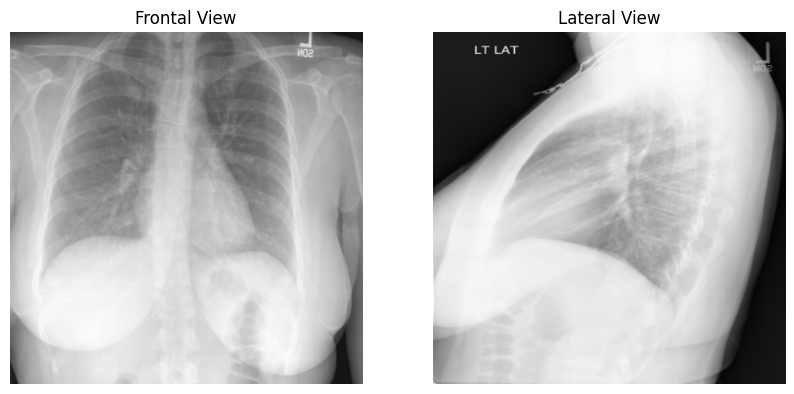

True Caption: The heart is normal in size and contour. There is no mediastinal widening. The lungs are clear bilaterally. No large pleural effusion or pneumothorax. Mild dextro curvature of the thoracic spine, possibly positional.
Pred Caption:  in the interval, consolidation has developed in the left lower lobe. Also, anterior segment XXXX opacity is present. Right lung remains clear. Heart size is normal.
--------------------------------------------------


In [36]:
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import warnings
import logging
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Disabilita tutti i warning
warnings.filterwarnings('ignore')
# Ignora i warning specifici di 'transformers'
warnings.filterwarnings("ignore", category=UserWarning, module="transformers")
# Imposta il livello di logging su ERROR per ignorare i messaggi INFO e WARNING
logging.getLogger("transformers").setLevel(logging.ERROR)

def calculate_bleu(pred_ids, ref_ids, tokenizer):
    """
    Calcola i punteggi BLEU-1, BLEU-2, BLEU-3, BLEU-4.
    """
    pred_tokens = tokenizer.convert_ids_to_tokens(pred_ids)
    ref_tokens = tokenizer.convert_ids_to_tokens(ref_ids)

    # Evita problemi con sequenze vuote
    if not pred_tokens or not ref_tokens:
        return (0.0, 0.0, 0.0, 0.0)

    smoothing = SmoothingFunction().method1
    bleu1 = sentence_bleu([ref_tokens], pred_tokens, weights=(1, 0, 0, 0), smoothing_function=smoothing)
    bleu2 = sentence_bleu([ref_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing)
    bleu3 = sentence_bleu([ref_tokens], pred_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing)
    bleu4 = sentence_bleu([ref_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing)

    return bleu1, bleu2, bleu3, bleu4

def calculate_rouge_l(predicted_text, reference_text):
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    score = scorer.score(reference_text, predicted_text)
    return score['rougeL'].fmeasure
    
def test(model, test_loader, tokenizer):
    model.eval()
    total_bleu1 = total_bleu2 = total_bleu3 = total_bleu4 = 0
    total_rouge_l = 0

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            # Genera i report solo dal latent space
            gen_ids = model.generate_report(
                front_image=batch['front_pixel_values'],
                lateral_img=batch['lateral_pixel_values'],
                device=device
            )

            # Calcolo dei punteggi BLEU e ROUGE-L sui testi generati
            for pred_ids, ref_ids in zip(gen_ids, batch['input_ids_caption']):
                bleu1, bleu2, bleu3, bleu4 = calculate_bleu(pred_ids.tolist(), ref_ids.tolist(), tokenizer)
                total_bleu1 += bleu1
                total_bleu2 += bleu2
                total_bleu3 += bleu3
                total_bleu4 += bleu4

                predicted_text = tokenizer.decode(pred_ids.tolist(), skip_special_tokens=True)
                reference_text = tokenizer.decode(ref_ids.tolist(), skip_special_tokens=True)
                rouge_l_score = calculate_rouge_l(predicted_text, reference_text)
                total_rouge_l += rouge_l_score

    dataset_size = len(test_loader.dataset)
    metrics = {
        'bleu1': total_bleu1 / dataset_size,
        'bleu2': total_bleu2 / dataset_size,
        'bleu3': total_bleu3 / dataset_size,
        'bleu4': total_bleu4 / dataset_size,
        'rouge_l': total_rouge_l / dataset_size
    }

    print("\nTest Results:")
    print(f"BLEU-1 Score: {metrics['bleu1']:.4f}")
    print(f"BLEU-2 Score: {metrics['bleu2']:.4f}")
    print(f"BLEU-3 Score: {metrics['bleu3']:.4f}")
    print(f"BLEU-4 Score: {metrics['bleu4']:.4f}")
    print(f"ROUGE-L Score: {metrics['rouge_l']:.4f}")

    return metrics

def visualize_predictions(model, test_loader, tokenizer, num_images=5):
    model.eval()
    visualizations_shown = 0

    with torch.no_grad():
        for batch in test_loader:
            gen_ids = model.generate_report(
                front_image=batch['front_pixel_values'],
                lateral_img=batch['lateral_pixel_values'],
                device=device
            )

            for i in range(len(gen_ids)):
                if visualizations_shown >= num_images:
                    return

                # Decode captions and problems
                pred_caption = tokenizer.decode(gen_ids[i].tolist(), skip_special_tokens=True)
                true_caption = tokenizer.decode(batch['input_ids_caption'][i].tolist(), skip_special_tokens=True)
                
                # Plot images
                plt.figure(figsize=(10, 5))

                # Plot frontal image
                plt.subplot(1, 2, 1)
                plt.imshow(batch['front_pixel_values'][i].cpu().permute(1, 2, 0))
                plt.axis('off')
                plt.title('Frontal View')

                # Plot lateral image
                plt.subplot(1, 2, 2)
                plt.imshow(batch['lateral_pixel_values'][i].cpu().permute(1, 2, 0))
                plt.axis('off')
                plt.title('Lateral View')

                plt.show()

                # Print predictions and true values
                print(f"True Caption: {true_caption}")
                print(f"Pred Caption: {pred_caption}")
                print('-' * 50)

                visualizations_shown += 1
                visualizations_shown += 1

# Assicurati che il modello sia sulla GPU prima di iniziare
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Run tests and visualize predictions
metrics = test(model, test_loader, tokenizer)
visualize_predictions(model, test_loader, tokenizer, num_images=2)

Accuracy su tutto il set di validazione: 94.90%

Accuratezze relative per classe:
Classe 0: 91.83% (326/355)
Classe 1: 98.51% (331/336)
Classe 2: 95.79% (91/95)
Classe 3: 93.68% (163/174)


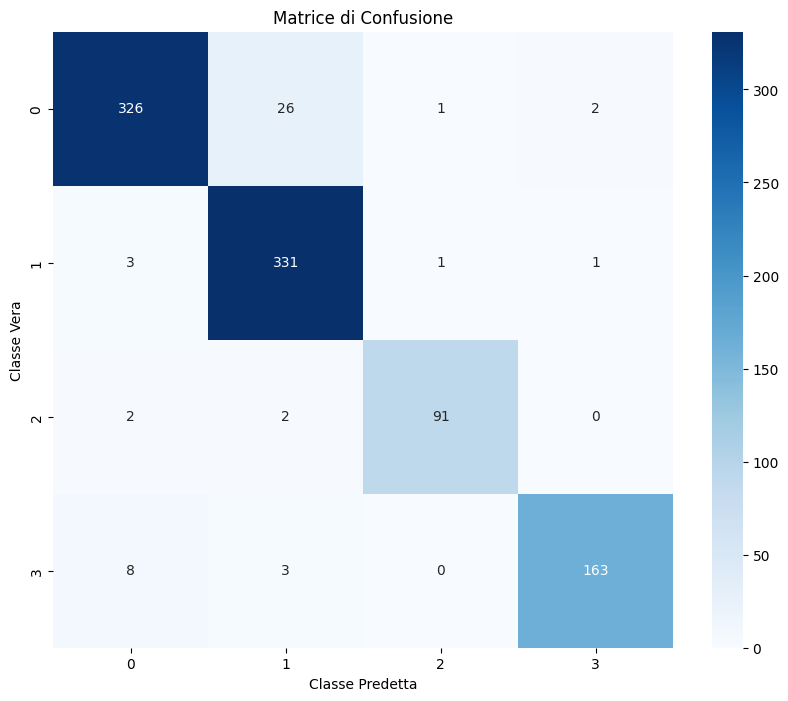


Dettagli predizioni:
Campione 1: Classe vera = 3, Classe predetta = 1
Campione 2: Classe vera = 1, Classe predetta = 1
Campione 3: Classe vera = 1, Classe predetta = 1
Campione 4: Classe vera = 0, Classe predetta = 3
Campione 5: Classe vera = 3, Classe predetta = 3
Campione 6: Classe vera = 1, Classe predetta = 1
Campione 7: Classe vera = 0, Classe predetta = 0
Campione 8: Classe vera = 0, Classe predetta = 0
Campione 9: Classe vera = 3, Classe predetta = 3
Campione 10: Classe vera = 0, Classe predetta = 0
Campione 11: Classe vera = 0, Classe predetta = 0
Campione 12: Classe vera = 1, Classe predetta = 1
Campione 13: Classe vera = 3, Classe predetta = 3
Campione 14: Classe vera = 1, Classe predetta = 1
Campione 15: Classe vera = 0, Classe predetta = 0
Campione 16: Classe vera = 0, Classe predetta = 0
Campione 17: Classe vera = 0, Classe predetta = 0
Campione 18: Classe vera = 3, Classe predetta = 3
Campione 19: Classe vera = 1, Classe predetta = 1
Campione 20: Classe vera = 1, Classe 

In [37]:
def evaluate_predictions_full(model, val_loader, num_class_pred= num_class_pred):
    import torch
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    correct_predictions = 0
    total_predictions = 0
    class_correct = torch.zeros(num_class_pred, dtype=torch.int32)
    class_total = torch.zeros(num_class_pred, dtype=torch.int32)
    all_predictions = []
    true_labels = []
    pred_labels = []
    
    with torch.no_grad():
        for batch in val_loader:
            # Recupera input e label
            front_image = batch['front_pixel_values']
            lateral_image = batch['lateral_pixel_values']
            labels = torch.argmax(batch['categories'], dim=1)
            
            # Forward
            outputs = model(
                front_image=front_image,
                lateral_img=lateral_image,
                input_ids_caption=batch['input_ids_caption'],
                attention_mask_caption=batch['attention_mask_caption'],
            )
            logits = outputs["classification_logits"]
            predicted_labels = torch.argmax(logits, dim=1)
            
            # Salva predizioni e vere etichette
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted_labels.cpu().numpy())
            
            for true_label, pred_label in zip(labels.tolist(), predicted_labels.tolist()):
                all_predictions.append((true_label, pred_label))
                
            # Accuratezza globale
            correct_predictions += (predicted_labels == labels).sum().item()
            total_predictions += labels.size(0)
            
            # Accuratezza di classe
            for class_label in range(num_class_pred):
                class_correct[class_label] += ((predicted_labels == class_label) &
                                           (labels == class_label)).sum().item()
                class_total[class_label] += (labels == class_label).sum().item()
    
    # Accuratezza globale
    accuracy = 100.0 * correct_predictions / total_predictions
    print(f"Accuracy su tutto il set di validazione: {accuracy:.2f}%")
    
    # Accuratezza per classe
    print("\nAccuratezze relative per classe:")
    for class_label in range(num_class_pred):
        if class_total[class_label] > 0:
            class_accuracy = 100.0 * class_correct[class_label] / class_total[class_label]
            print(f"Classe {class_label}: {class_accuracy:.2f}% "
                  f"({class_correct[class_label]}/{class_total[class_label]})")
        else:
            print(f"Classe {class_label}: Nessun campione presente.")
    
    # Calcola e visualizza la matrice di confusione
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Matrice di Confusione')
    plt.ylabel('Classe Vera')
    plt.xlabel('Classe Predetta')
    plt.show()
    
    # Stampa tutte le predizioni
    print("\nDettagli predizioni:")
    for i, (true_label, pred_label) in enumerate(all_predictions):
        print(f"Campione {i + 1}: Classe vera = {true_label}, Classe predetta = {pred_label}")

    return accuracy, cm

accuracy, confusion_matrix = evaluate_predictions_full(model, test_loader)